In [697]:
# build the networks
using LinearAlgebra
using SparseArrays
using Combinatorics
using EzXML
posts_doc = readxml("mathoverflow/Posts.xml")
comments_doc = readxml("mathoverflow/Comments.xml")

EzXML.Document(EzXML.Node(<DOCUMENT_NODE@0x000000004c0ece70>))

In [823]:
allposts = root(posts_doc)
alltags = Array{String}(undef,0)
postids = Array{Int}(undef,0)
ownerids = Array{Int}(undef,0)
posttags = Array{Array{String}}(undef,0)
postanswers = Array{Array{Int}}(undef,0)
postcomments = Array{Array{Int}}(undef,0)
remainderposts = Array{EzXML.Node}(undef,0)


answersid = Array{Int}(undef,0)
answersownerid = Array{Int}(undef,0)

for post in eachelement(allposts)
    if haskey(post,"OwnerUserId")
        # Get an attribute value by name.
        if parse(Int,post["PostTypeId"]) == 1 # it was a question
            postid = parse(Int,post["Id"])
            ownerid = parse(Int,post["OwnerUserId"])
            tags = unique(reduce(vcat, split.(split(post["Tags"],"<"),">")))[2:end]

            push!(postids,postid)
            push!(ownerids,ownerid)
            push!(posttags,tags)
            push!(postanswers,Vector{Int}(undef,0))
            push!(postcomments,Vector{Int}(undef,0))
        else # it was an answer
            if haskey(post,"ParentId")
                parentid = findfirst(postids.==parse(Int,post["ParentId"]))
                if parentid == nothing
                    push!(remainderposts,post)
                else
                    ownerid = parse(Int,post["OwnerUserId"])
                    push!(postanswers[parentid],ownerid)
                    push!(answersid,parse(Int,post["Id"]))
                    push!(answersownerid,ownerid)
                end
            end
        end
    end
end
# remainderposts
remainderposts2 = Array{EzXML.Node}(undef,0)
for post in remainderposts
    parentid = findfirst(postids.==parse(Int,post["ParentId"]))
    if parentid == nothing
        push!(remainderposts2,post)
    else
        ownerid = parse(Int,post["OwnerUserId"])
        push!(postanswers[parentid],ownerid)
        push!(answersid,parse(Int,post["Id"]))
        push!(answersownerid,ownerid)
    end
end
remainderposts2; # these will get discarded as the parent is not found

In [818]:
# allposts = root(posts_doc)
# alltags = Array{String}(undef,0)
# postids = Array{Int}(undef,0)
# ownerids = Array{Int}(undef,0)
# posttags = Array{Array{String}}(undef,0)
# postanswers = Array{Array{Int}}(undef,0)
# remainderposts = Array{EzXML.Node}(undef,0)


# form triangles between:
# ownerids,postanswers,posttags

In [829]:
commentanswernode = Array{Array{Int}}(undef,length(answersid))
map(i->commentanswernode[i]=[],1:length(commentanswernode))
# answersownerid - commentanswernode are the edges within A
# ownserids - postcomments are edges within Q
# postags are edges within each group (T)

# ownerids - postanswers - posttags are the intermodal links


In [833]:
# read comments.xml

allcomments = root(comments_doc)
for comment in eachelement(allcomments)
    if haskey(comment,"UserId")
        uid = parse(Int,comment["UserId"])
        id = findfirst(postids.==parse(Int,comment["PostId"]))
        if id != nothing
            push!(postcomments[id],uid)
        else 
            id = findfirst(answersid.==parse(Int,comment["PostId"]))
            if id != nothing
                push!(commentanswernode[id],uid)
            end
            # else discard
        end
    end
end

In [845]:
utags = unique(reduce(vcat,posttags))
nT = length(utags)
uquestions = unique(vcat(unique(reduce(vcat,postcomments)),unique(ownerids)))
nQ = length(uquestions)
uanswers = unique(vcat(unique(reduce(vcat,commentanswernode)),unique(answersownerid)))
nA = length(uanswers)

@show nT,nQ,nA

(nT, nQ, nA) = (3034, 175918, 152696)


(3034, 175918, 152696)

In [881]:
# mapping is if tag/q/a is i, then original id is utags[i]/uquestions[i]/uanswers[i]
# time to build 6 networks

# 1 # Tag-Tag
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for tagbundle in posttags
    newids = findin_index(tagbundle,utags)
    for comb in combinations(newids,2)
        push!(ei,comb[1])
        push!(ej,comb[2])
    end
end
TagTag = spones(sparse(ei,ej,1,nT,nT))
TagTag = max.(TagTag,TagTag')
;

In [888]:
# 2 # Question - Tag
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(ownerids)
    id = ownerids[i]
    oid = findfirst(uquestions.==id)
    tagbundle = posttags[i]
    newidstags = findin_index(tagbundle,utags)
    for ti in newidstags
        push!(ei,oid)
        push!(ej,ti)
    end
end
QuestionTag = spones(sparse(ei,ej,1,nQ,nT));

In [896]:
# 3 # Question - Answers
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(ownerids)
    id = ownerids[i]
    oid = findfirst(uquestions.==id)
    answersbundle = postanswers[i]
    newidsanswers = findin_index(answersbundle,uanswers)
    for ti in newidsanswers
        push!(ei,oid)
        push!(ej,ti)
    end
end
QuestionAnswer = spones(sparse(ei,ej,1,nQ,nA));

In [907]:
ownerids

306703-element Array{Int64,1}:
      5
     35
     10
     27
     43
     50
     56
     63
     39
     71
     20
     24
     50
      ⋮
 899018
 468193
 898237
 855175
 811661
 899029
 876609
 899033
 899034
 889228
 899035
 899037

In [929]:
# 4 # Question - Question
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(ownerids)
    @show (i,length(ownerids))
    id = ownerids[i]
    oid = findfirst(uquestions.==id)
    commentsbundle = postcomments[i]
    newidsquestions = findin_index(commentsbundle,uquestions)
    for ti in newidsquestions
        push!(ei,oid)
        push!(ej,ti)
        @show (oid,ti)
    end
end
QuestionQuestion = spones(sparse(ei,ej,1,nQ,nQ));
QuestionQuestion = max.(QuestionQuestion,QuestionQuestion');

In [931]:
# 5 # Answer - Tag
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(postanswers)
    ai = postanswers[i]
    ti = posttags[i]
    newids_answers = findin_index(ai,uanswers)
    newids_tags = findin_index(ti,utags)
    for answerid in newids_answers
        for tagid in newids_tags
            push!(ei,answerid)
            push!(ej,tagid)
        end
    end
end
AnswerTag = spones(sparse(ei,ej,1,nA,nT));

In [932]:
# 6 # Answer - Answer
# Part 1
# answersownerid - commentanswernode
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(answersownerid)
    id = answersownerid[i]
    oid = findfirst(uanswers.==id)
    commentbundle = commentanswernode[i]
    newidsanswers = findin_index(commentbundle,uanswers)
    for ti in newidsanswers
        push!(ei,oid)
        push!(ej,ti)
    end
end
AnswerAnswer1 = spones(sparse(ei,ej,1,nA,nA))

# Part 2
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for answerbundle in postanswers
    newids = findin_index(answerbundle,uanswers)
    for comb in combinations(newids,2)
        push!(ei,comb[1])
        push!(ej,comb[2])
    end
end
AnswerAnswer2 = spones(sparse(ei,ej,1,nA,nA))

AnswerAnswer = AnswerAnswer1+AnswerAnswer2
AnswerAnswer = max.(AnswerAnswer,AnswerAnswer')

152696×152696 SparseMatrixCSC{Int64,Int64} with 990378 stored entries:
  [9     ,      1]  =  1
  [9     ,      2]  =  1
  [15    ,      2]  =  1
  [80    ,      2]  =  1
  [110   ,      2]  =  1
  [188   ,      2]  =  1
  [1570  ,      2]  =  1
  [2639  ,      2]  =  1
  [3983  ,      2]  =  1
  [4589  ,      2]  =  1
  [5525  ,      2]  =  1
  [15061 ,      2]  =  1
  ⋮
  [102549, 152695]  =  1
  [102563, 152695]  =  1
  [102577, 152695]  =  1
  [102728, 152695]  =  1
  [107117, 152695]  =  1
  [152694, 152695]  =  1
  [567   , 152696]  =  1
  [19346 , 152696]  =  1
  [29061 , 152696]  =  1
  [29848 , 152696]  =  1
  [96195 , 152696]  =  1
  [102965, 152696]  =  1

In [934]:
n0 = [nQ,nA,nT]
A = vcat(hcat(QuestionQuestion,QuestionAnswer,QuestionTag),
    hcat(QuestionAnswer',AnswerAnswer,AnswerTag),
    hcat(QuestionTag',AnswerTag',TagTag))
M = create_subnetworks(A,3,n0);
M0 = A
M1 = vcat(hcat(spzeros(M[1]),M[2]',M[4]'),hcat(M[2],spzeros(M[3]),M[5]'),hcat(M[4],M[5],spzeros(M[6])));

floor(0.0001 * length(i1)) = 36.0


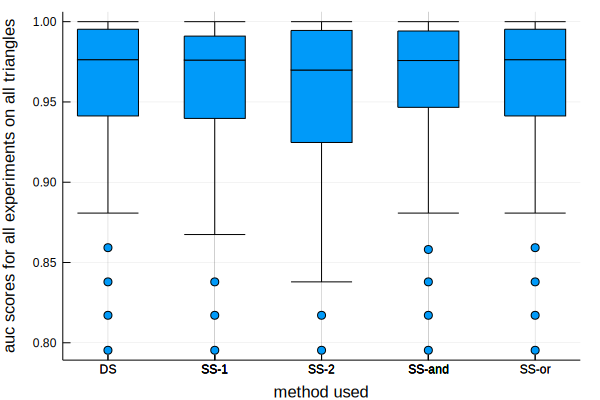

In [946]:
all_aucs_new = general_double_seed_idea(
    M,
    n0,
    "edge",#"edge","triangle"
    0.0001,
    0.8);

@show floor(0.0001*length(i1))
aucvals = all_aucs_new
boxplot(["DS" "SS-1" "SS-2" "SS-and" "SS-or"],aucvals, legend = false,color=1)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")

floor(0.0001 * length(i1)) = 36.0


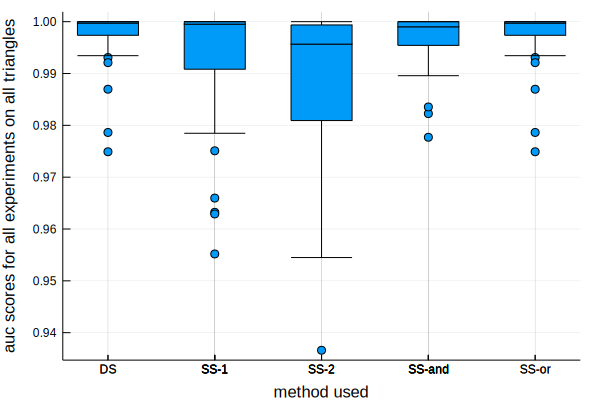

In [947]:
all_aucs_new_2 = general_double_seed_idea(
    M,
    n0,
    "wedge",#"edge","triangle"
    0.0001,
    0.8);

@show floor(0.0001*length(i1))
aucvals = all_aucs_new_2
boxplot(["DS" "SS-1" "SS-2" "SS-and" "SS-or"],aucvals, legend = false,color=1)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")

floor(0.0001 * length(i1)) = 36.0


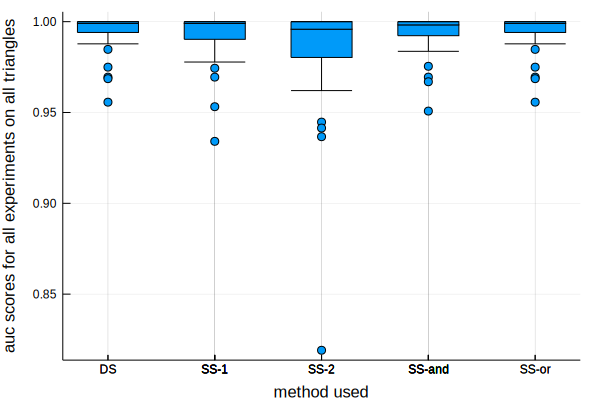

In [948]:
all_aucs_new_3 = general_double_seed_idea(
    M,
    n0,
    "wedge",#"edge","triangle"
    0.0001,
    0.8);

@show floor(0.0001*length(i1))
aucvals = all_aucs_new_3
boxplot(["DS" "SS-1" "SS-2" "SS-and" "SS-or"],aucvals, legend = false,color=1)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")

In [ ]:
# include("all_code/methods.jl")
# all_aucs_new = general_double_seed_idea_all_methods(
#     M,
#     n0,
#     "edge",#"edge","triangle"
#     0.0002,
#     0.8,
#     A);

# aucvals = all_aucs_new
# boxplot(["DS-HK" "SS1-HK" "SS2-HK" "DS-PR" "SS1-PR" "SS2-PR" "C1-HK" "C2-HK" "C1-PR" "C2-PR" "EdgeRank"],aucvals, legend = false,color=1)
# xlabel!("method used")
# ylabel!("auc scores for all experiments on all triangles")
# plot!(xrotation=60)